In [3]:
import collections
import math

import dill
import pytest
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cv2 as cv
import carla

from collect.generate.map import MapDataExtractor
import collect.visualize.trajectron
import utility.npu
import utility as util
import carlautil

CARLA_HOST = '127.0.0.1'
CARLA_PORT = 2000
DELTA = 0.1
PRECISION = 1.0

In [4]:
def get_world_with(client, map_name):
    world = client.get_world()
    carla_map = world.get_map()
    if carla_map.name != map_name:
        world = client.load_world(map_name)
        carla_map = world.get_map()
    return world, carla_map

def get_client_and_world_with(map_name):
    client = carla.Client(CARLA_HOST, CARLA_PORT)
    client.set_timeout(10.0)
    world, carla_map = get_world_with(client, map_name)
    return client, world, carla_map

roadpath = '../cache/map_data.Town03.pkl'
with open(roadpath, 'rb') as f:
    map_data = dill.load(f, encoding='latin1')
    map_data = util.AttrDict(map_data)

In [5]:
def to_point(wp):
    x, y, _ = carlautil.to_location_ndarray(wp)
    return [x, -y]

def collect_points_along_waypoint(start_wp, choices, max_distance, mask_junction=False):
    """Collects points along path on a CARLA map, beginning with provided waypoint.
    
    Parameters
    ==========
    start_wp : carla.Waypoint
        Waypoint designating the start of the path.
    choices : list of int
        Indices of turns at each junction along the path from start_wp onwards.
        If there are more junctions than indices contained in choices, then 
        choose default turn. 
    max_distance : float
        Maximum distance of path from start_wp we want to sample from.
    mask_junction : bool
        Whether to mask points.
    
    
    Returns
    =======
    np.array of float
        Sampled points along path starting from waypoint start_wp.
    float
        Accumulated distance from the first point to the last on the path.
    np.array of bool
        Mask for sample points on a junction if mask_junction=True.
    """
    wp = start_wp
    wps = [wp]
    points = [to_point(wp)]
    cum_distance = 0.
    iidx = 0
    while cum_distance < max_distance:
        next_wps = wp.next(PRECISION)
        if len(next_wps) > 1:
            try:
                wp = next_wps[choices[iidx]]
            except IndexError:
                wp = next_wps[0]
            iidx += 1
        else:
            wp = next_wps[0]
        wps.append(wp)
        points.append(to_point(wp))
        x1, y1 = points[-2]
        x2, y2 = points[-1]
        cum_distance += np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    points = np.array(points)
    if mask_junction:
        junction_mask = util.map_to_ndarray(lambda wp: wp.is_junction, wps)
        return points, cum_distance, junction_mask
    else:
        return points, cum_distance

In [6]:
client, world, carla_map = get_client_and_world_with("Town03")

In [7]:
spawn_points = carla_map.get_spawn_points()

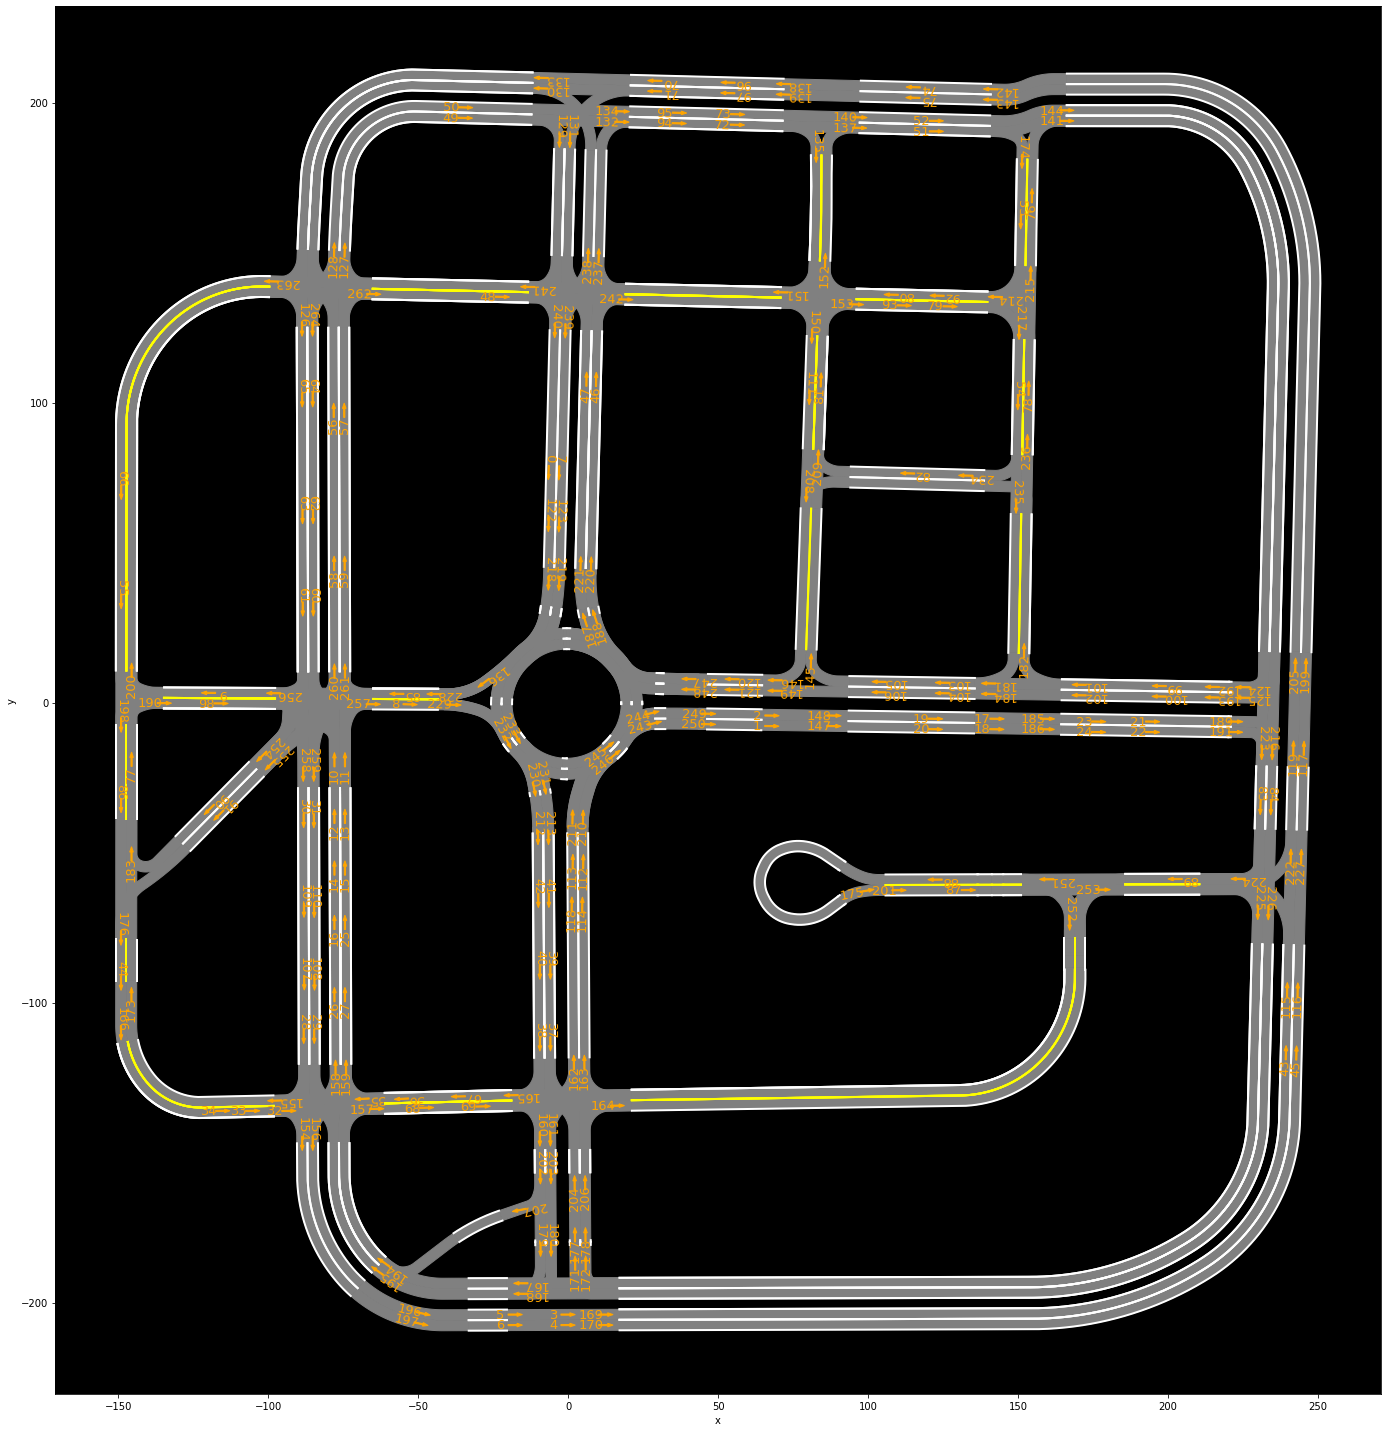

In [23]:
# Plot map overlay and label spawning points.
fig, ax = plt.subplots(figsize=(20,20))
collect.visualize.trajectron.render_entire_map(ax, map_data)

for idx, sp in enumerate(spawn_points):
    spp = carla.Transform(
            sp.location - 2.5 * sp.get_forward_vector(),
            sp.rotation)
    x, y, _ = carlautil.to_location_ndarray(spp)
    _, yaw, _ = carlautil.to_rotation_ndarray(sp)
    yaw = util.reflect_radians_about_x_axis(yaw)
    ax.text(
        x, -y, str(idx), color='orange', size=13, rotation=np.rad2deg(yaw),
        ha="center", va="center",
    )
    x, y, _ = carlautil.to_location_ndarray(sp)
    ax.arrow(x, -y, 3*np.cos(yaw), 3*np.sin(yaw), width=0.4, color='orange')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()

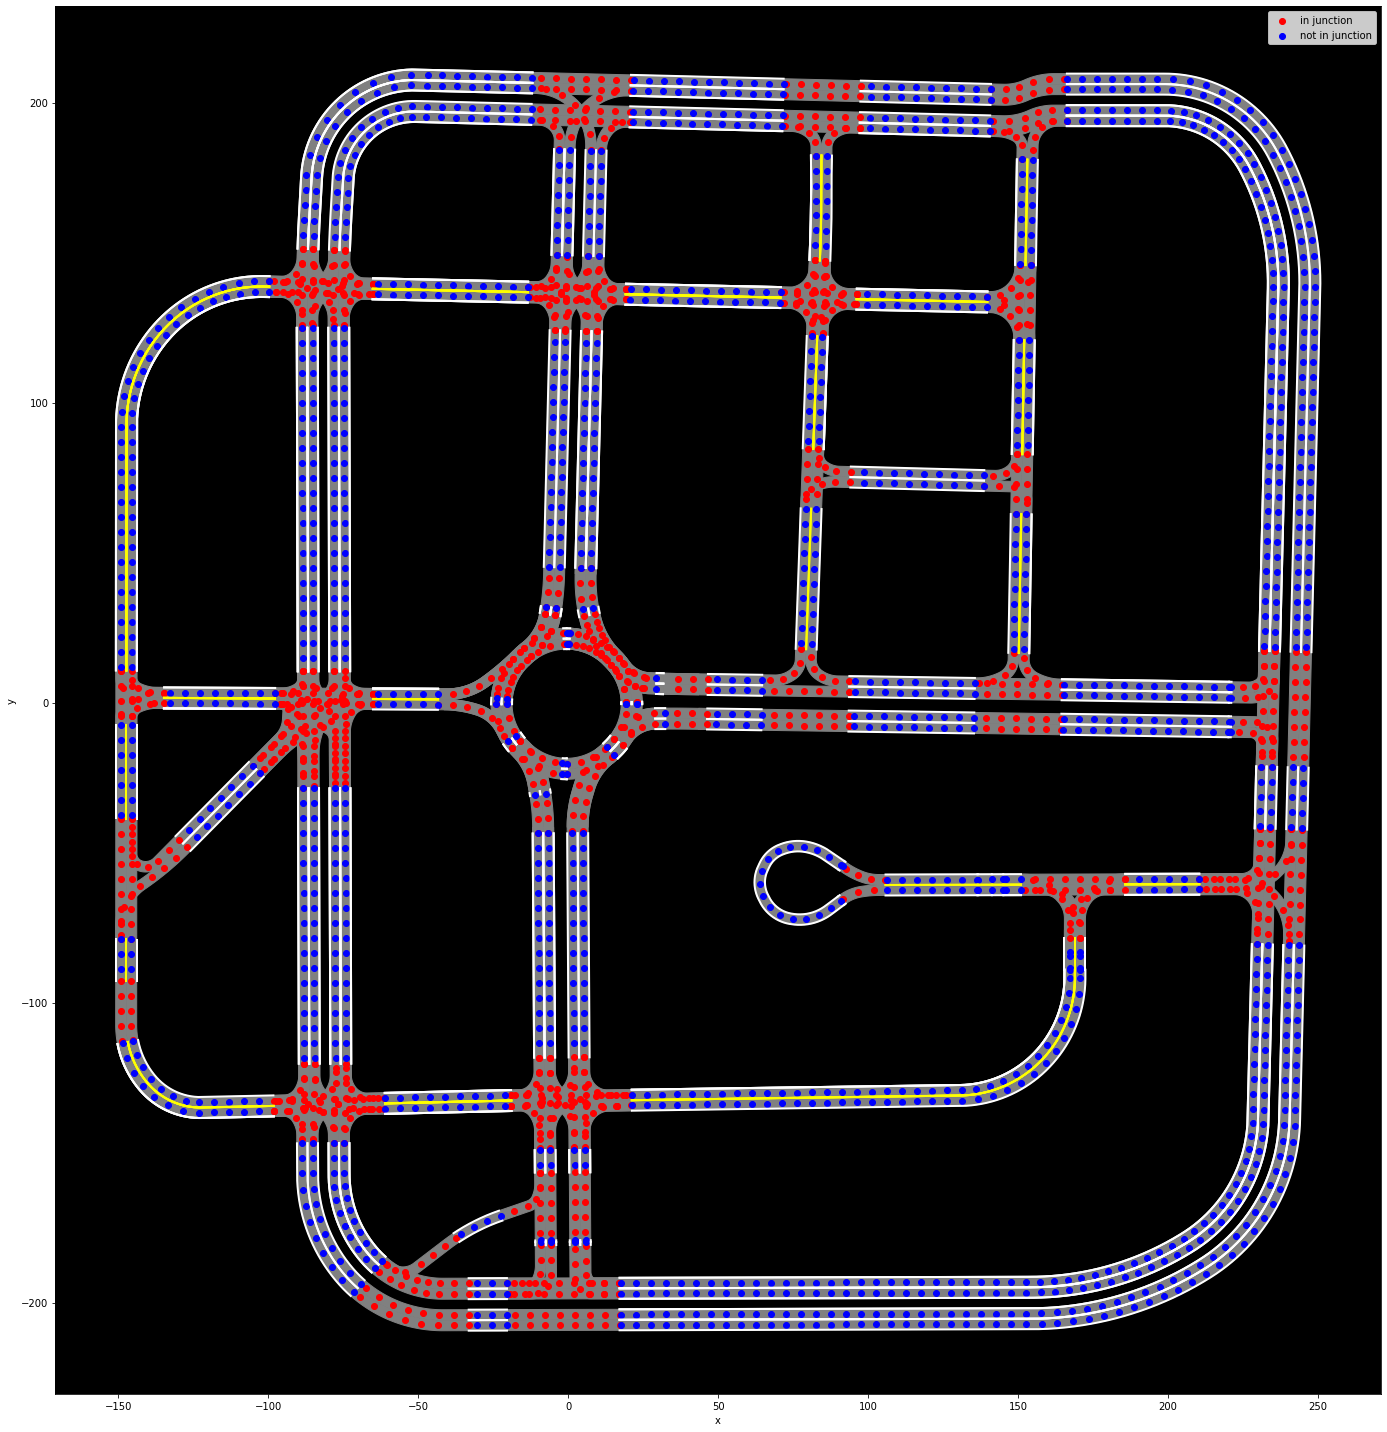

In [60]:
# Plot map overlay and label points on the road inside/outside road junctions.
fig, ax = plt.subplots(figsize=(20,20))
collect.visualize.trajectron.render_entire_map(ax, map_data)

wps = carla_map.generate_waypoints(5)
points = util.map_to_ndarray(to_point, wps)
junction_mask = util.map_to_ndarray(lambda wp: wp.is_junction, wps)
ax.scatter(*points[junction_mask].T, c="r", label="in junction")
ax.scatter(*points[~junction_mask].T, c="b", label="not in junction")
ax.legend()

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()

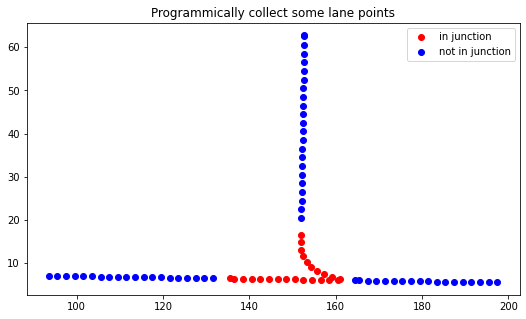

In [76]:
# Apply a mask on waypoints inside of an intersection.
# Show that waypoints inside an intersection can be labelled.

# Getting straight lanes
PRECISION = 2.0
starting_point = 99
sp = spawn_points[starting_point]
wp = carla_map.get_waypoint(sp.location)

# Programmically collect some lane points
coll_wps = []
wps = wp.next_until_lane_end(PRECISION)
coll_wps.append(wps)

wp = wps[-1]
intersect_wps = wp.next(PRECISION)
wp1, wp2 = intersect_wps

wps = wp2.next_until_lane_end(PRECISION)
coll_wps.append(wps)

wp = wps[-1]
intersect_wps = wp.next(PRECISION)
wp4 = intersect_wps[0]

wps = wp1.next_until_lane_end(PRECISION)
coll_wps.append(wps)

wp = wps[-1]
intersect_wps = wp.next(PRECISION)
wp3 = intersect_wps[0]

wps = wp3.next_until_lane_end(PRECISION)
coll_wps.append(wps)

wps = wp4.next_until_lane_end(PRECISION)
coll_wps.append(wps)

fig, ax = plt.subplots(figsize=(20,5))
wps = util.merge_list_of_list(coll_wps)
points = util.map_to_ndarray(to_point, wps)
junction_mask = util.map_to_ndarray(lambda wp: wp.is_junction, wps)
ax.scatter(*points[junction_mask].T, c="r", label="in junction")
ax.scatter(*points[~junction_mask].T, c="b", label="not in junction")
ax.set_title("Programmically collect some lane points")
ax.set_aspect('equal')
ax.legend()
None

Encountered junction with 1 forks.
Encountered junction with 1 forks.
Encountered junction with 2 forks.
Encountered junction with 1 forks.
Encountered junction with 1 forks.
Encountered junction with 1 forks.
Encountered junction with 1 forks.


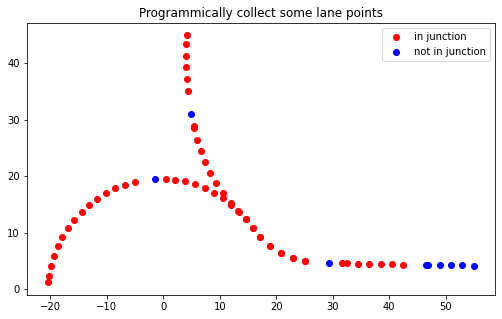

In [77]:
# Apply a mask on waypoints inside of an roundabout.
# Show that waypoints inside an intersection can be labelled.

PRECISION = 2.0
starting_point = 121
sp = spawn_points[starting_point]
wp = carla_map.get_waypoint(sp.location)

# Programmically collect some lane points
coll_wps = []
wps = wp.next_until_lane_end(PRECISION)
coll_wps.append(wps)

wp = wps[-1]
intersect_wps = wp.next(PRECISION)
wp1 = intersect_wps[0]
print(f"Encountered junction with {len(intersect_wps)} forks.")

wps = wp1.next_until_lane_end(PRECISION)
coll_wps.append(wps)

wp = wps[-1]
intersect_wps = wp.next(PRECISION)
wp2 = intersect_wps[0]
print(f"Encountered junction with {len(intersect_wps)} forks.")

wps = wp2.next_until_lane_end(PRECISION)
coll_wps.append(wps)

wp = wps[-1]
intersect_wps = wp.next(PRECISION)
wp3, wp4 = intersect_wps
print(f"Encountered junction with {len(intersect_wps)} forks.")

wps = wp3.next_until_lane_end(PRECISION)
coll_wps.append(wps)

wp = wps[-1]
intersect_wps = wp.next(PRECISION)
wp5 = intersect_wps[0]
print(f"Encountered junction with {len(intersect_wps)} forks.")

wps = wp5.next_until_lane_end(PRECISION)
coll_wps.append(wps)

wp = wps[-1]
intersect_wps = wp.next(PRECISION)
wp6 = intersect_wps[0]
print(f"Encountered junction with {len(intersect_wps)} forks.")

wps = wp6.next_until_lane_end(PRECISION)
coll_wps.append(wps)

wps = wp4.next_until_lane_end(PRECISION)
coll_wps.append(wps)

wp = wps[-1]
intersect_wps = wp.next(PRECISION)
wp7 = intersect_wps[0]
print(f"Encountered junction with {len(intersect_wps)} forks.")

wps = wp7.next_until_lane_end(PRECISION)
coll_wps.append(wps)

wp = wps[-1]
intersect_wps = wp.next(PRECISION)
wp8 = intersect_wps[0]
print(f"Encountered junction with {len(intersect_wps)} forks.")

wps = wp8.next_until_lane_end(PRECISION)
coll_wps.append(wps)

fig, ax = plt.subplots(figsize=(20,5))
wps = util.merge_list_of_list(coll_wps)
points = util.map_to_ndarray(to_point, wps)
junction_mask = util.map_to_ndarray(lambda wp: wp.is_junction, wps)
ax.scatter(*points[junction_mask].T, c="r", label="in junction")
ax.scatter(*points[~junction_mask].T, c="b", label="not in junction")
ax.set_title("Programmically collect some lane points")
ax.set_aspect('equal')
ax.legend()

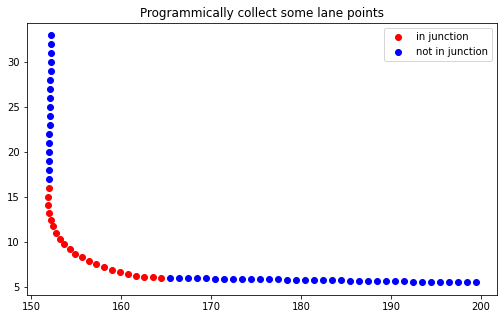

In [8]:
# Programmically collect points and mask them by junction

starting_point = 99
sp = spawn_points[starting_point]
start_wp = carla_map.get_waypoint(sp.location)
max_distance = 70
choices = []
points, path_length, junction_mask = collect_points_along_waypoint(
    start_wp, choices, max_distance, mask_junction=True
)

fig, ax = plt.subplots(figsize=(20,5))
ax.scatter(*points[junction_mask].T, c="r", label="in junction")
ax.scatter(*points[~junction_mask].T, c="b", label="not in junction")
ax.set_title("Programmically collect some lane points")
ax.set_aspect('equal')
ax.legend()
None

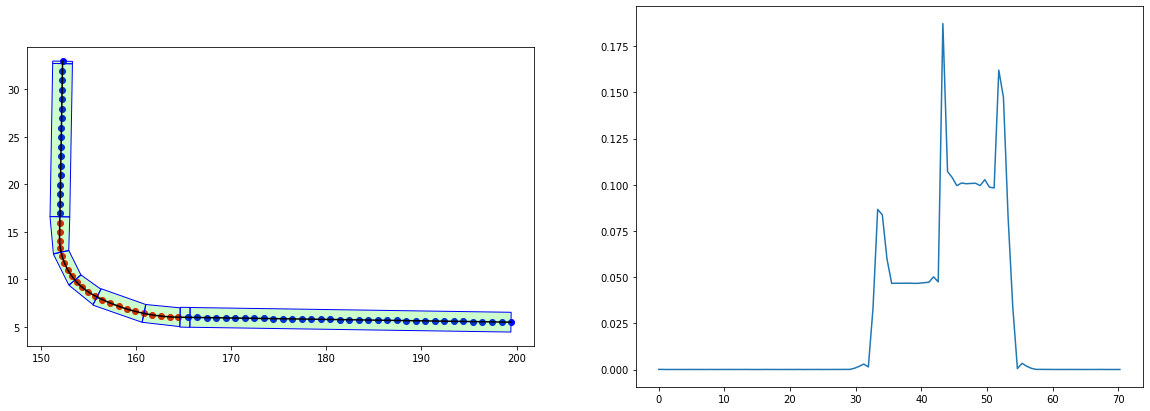

In [24]:


starting_point = 99
sp = spawn_points[starting_point]
start_wp = carla_map.get_waypoint(sp.location)
max_distance = 70
choices = []
points, path_length, junction_mask = collect_points_along_waypoint(
    start_wp, choices, max_distance, mask_junction=True
)
n_points, _ = points.shape
distances = np.linspace(0, path_length, n_points)

# downsample points on spline
# _spline = scipy.interpolate.CubicSpline(distances, points, axis=0) # no improvement
# n_points, _ = points.shape
# distances = np.linspace(0, path_length, n_points // 5)
# points = _spline(distances)

spline = scipy.interpolate.CubicSpline(distances, points, axis=0)
# spline = scipy.interpolate.Akima1DInterpolator(distances, points, axis=0) # no progression
# spline = scipy.interpolate.BarycentricInterpolator(distances, points, axis=0) # no derivative
# spline = scipy.interpolate.krogh_interpolate(distances, points, x?, der=2, axis=0) # no convenient derivative
# spline = scipy.interpolate.PchipInterpolator(distances, points, axis=0) # no progression

dspline = spline.derivative(1)
ddspline = spline.derivative(2)

fig, axes = plt.subplots(1, 2, figsize=(20, 7))
axes = axes.ravel()
# plot the spline
plot_distances = np.linspace(0, path_length, 100)
axes[0].scatter(*points[junction_mask].T, c="r", label="in junction")
axes[0].scatter(*points[~junction_mask].T, c="b", label="not in junction")
axes[0].plot(*spline(plot_distances).T, "-k", label="spline")
axes[0].set_aspect("equal")

# changes = np.linalg.norm(dspline(plot_distances), axis=1)
# axes[1].plot(plot_distances, changes)
curvatures = np.linalg.norm(ddspline(plot_distances), axis=1)
axes[1].plot(plot_distances, curvatures)

def compute_curvatue(d):
    """Find the curvature given distance from start of spline."""
    return np.linalg.norm(ddspline(d))

def compute_segment_length(delta, k):
    return 2*np.arccos(1/(k*delta + 1))/k

def compute_violation(delta, s, k):
    if s*k < math.pi:
        return max(0., 1 - (1 + delta*k)*np.cos(0.5*k*s))
    else:
        return 1.

def compute_cover_vertices(dist1, dist2, delta=1.):
    """Compute vertices of 4 sided cover for spline."""
    X1   = spline(dist1)
    X2   = spline(dist2)
    diff = 0.5
    # don't use second derivative
    X1p = spline(dist1 + diff)
    unit1 = util.npu.unit_normal_2d(X1, X1p)
    X2p = spline(dist2 - diff)
    unit2 = util.npu.unit_normal_2d(X2p, X2)
    p1 = X1 + delta*unit1
    p2 = X2 + delta*unit2
    p3 = X2 - delta*unit2
    p4 = X1 - delta*unit1
    
    return np.stack((p1, p2, p3, p4))

def cover_along_waypoints_varyingsize():
    vertex_set = []
    stepsize = 0.5
    acc_distance = 0
    while acc_distance < path_length:
        k = compute_curvatue(acc_distance)
        segment_length = compute_segment_length(0.25, k)
        segment_length = min(segment_length, path_length - acc_distance)
        query_distances = np.arange(acc_distance, acc_distance + segment_length, stepsize)
        query_distance = None
        if query_distances.size == 1:
            """place bounding box between acc_distance and (acc_distance + segment_length)"""
            next_distance = acc_distance + segment_length
        else:
            """since curvature of spline may change, figure out the maximum distance ahead
            from initial distance where the curvature does not change drastically."""
            prev_query_distance = None
            for query_distance in query_distances:
                k1 = compute_curvatue(query_distance)
                k2 = compute_curvatue(query_distance + stepsize)
                has_viol1 = compute_violation(0.25, segment_length, k1) > 0.03
                has_viol2 = compute_violation(0.25, segment_length, k2) > 0.03
                if has_viol1 and has_viol2:
                    break
            next_distance = query_distance
        vertices = compute_cover_vertices(acc_distance, next_distance, delta=2.0)#, delta=0.25)
        vertex_set.append(vertices)
        if acc_distance == next_distance:
            raise Exception("no progression")
        acc_distance = next_distance
    return vertex_set

vertex_set = cover_along_waypoints_varyingsize()
for vertices in vertex_set:
    patch = patches.Polygon(vertices, fill=True, fc=(0, 1, 0, 0.2), color='b')
    axes[0].add_patch(patch)

In [ ]:

def RoadBoundaryConstraint(object):
    """Create bounding boxes for road boundary."""

    def __init__(self, start_wp, max_distance, choices=[]):
        """Constructor.
    
        Parameters
        ==========
        start_wp : carla.Waypoint
            Waypoint designating the start of the path.
        max_distance : float
            Maximum distance of path from start_wp we want to sample from.
        choices : list of int
            Indices of turns at each junction along the path from start_wp onwards.
            If there are more junctions than indices contained in choices, then 
            choose default turn. 
        """
        points, path_length, junction_mask = collect_points_along_waypoint(
            start_wp, choices, max_distance, mask_junction=True
        )

    def compute_curvatue(d):
        """Find the curvature given distance from start of spline."""
        return np.linalg.norm(ddspline(d))

def compute_segment_length(delta, k):
    return 2*np.arccos(1/(k*delta + 1))/k

def compute_violation(delta, s, k):
    if s*k < math.pi:
        return max(0., 1 - (1 + delta*k)*np.cos(0.5*k*s))
    else:
        return 1.

def compute_cover_vertices(dist1, dist2, delta=1.):
    """Compute vertices of 4 sided cover for spline."""
    X1   = spline(dist1)
    X2   = spline(dist2)
    diff = 0.5
    # don't use second derivative
    X1p = spline(dist1 + diff)
    unit1 = util.npu.unit_normal_2d(X1, X1p)
    X2p = spline(dist2 - diff)
    unit2 = util.npu.unit_normal_2d(X2p, X2)
    p1 = X1 + delta*unit1
    p2 = X2 + delta*unit2
    p3 = X2 - delta*unit2
    p4 = X1 - delta*unit1
    
    return np.stack((p1, p2, p3, p4))

def cover_along_waypoints_varyingsize():
    vertex_set = []
    stepsize = 0.5
    acc_distance = 0
    while acc_distance < path_length:
        k = compute_curvatue(acc_distance)
        segment_length = compute_segment_length(0.25, k)
        segment_length = min(segment_length, path_length - acc_distance)
        query_distances = np.arange(acc_distance, acc_distance + segment_length, stepsize)
        query_distance = None
        if query_distances.size == 1:
            """place bounding box between acc_distance and (acc_distance + segment_length)"""
            next_distance = acc_distance + segment_length
        else:
            """since curvature of spline may change, figure out the maximum distance ahead
            from initial distance where the curvature does not change drastically."""
            prev_query_distance = None
            for query_distance in query_distances:
                k1 = compute_curvatue(query_distance)
                k2 = compute_curvatue(query_distance + stepsize)
                has_viol1 = compute_violation(0.25, segment_length, k1) > 0.03
                has_viol2 = compute_violation(0.25, segment_length, k2) > 0.03
                if has_viol1 and has_viol2:
                    break
            next_distance = query_distance
        vertices = compute_cover_vertices(acc_distance, next_distance, delta=2.0)#, delta=0.25)
        vertex_set.append(vertices)
        if acc_distance == next_distance:
            raise Exception("no progression")
        acc_distance = next_distance
    return vertex_set
